In [1]:
# Import packages
%matplotlib inline
import pandas as pd, numpy as np, matplotlib.pyplot as plt, calendar
import os
import seaborn as sns; sns.set(style="ticks", color_codes=True)
from scipy.stats import boxcox
import bayes_net_utils as bn

# Introduction

Notebook for generating:

1) a training data set for the Gaussian Bayesian Network set up for predicting water chemistry and ecology in Vansjø as part of the WATExR project (see notebook Fit_BN_1Season).

2) at the same time, a csv of observed seasonal data, just for the variables that are predicted by the Bayesian network, for use when manually calculating goodness-of-fit statistics of predictions

# User input

Paths to files and folders, and some other settings

In [2]:
# PATHS TO FILES AND FOLDERS
met_source = 'era5' # Choose from 'metno', 'era5'

# End year of data available
end_yr_dict = {'metno': 2018,
               'era5': 2019}

# Met (precipitation, wind)
met_fpath_dict = {'metno': r'../../Data/Meteorological/Obs_metno/Obs_Metno_1km_gridded_Morsa_v2.csv',
                  'era5': r'../../Data/Meteorological/06_era5/era5_morsa_1980-2019_daily.csv'}

if met_source == 'metno': # Wind is in a separate file
    wind_fpath = r'../../Data/Meteorological/Obs_metno/Obs_Rygge_MeanWindSpeed.csv' # Mean daily wind speed (m/s), Rygge airport

# Lake water quality
lakewq_fpath = r'../../Data/Observed_Chem_Ecol/Van2_Vanemfjorden_chem_obs.csv'

# Alternative lake colour data (from Storefjorden, 20m depth, MOVAR data)
movar_color_fpath = r'../../Data/Observed_Chem_Ecol/LakeColour_MOVAR.csv'

# Lake ecology (PTI, biovolume, cyanomax, cyano biovolume)
ecol_fpath = r'../../Data/Observed_Chem_Ecol/Van2_Vanemfjorden_Cyanobacteria.csv'

# Output folders
out_file_training = r'../Data/BN_TrainingData/TrainingData_GaussianBN_%s_1981-%s.csv' %(met_source,end_yr_dict[met_source])
tseries_plot_fpath = r'../Data/BN_TrainingData/Timeseries/TrainingData_GBN_%s_1981-%s.png' %(met_source,end_yr_dict[met_source])
out_file_obs = r'../Data/DataMatrices/Seasonal_BN_obs/seasonal_obs_GBN_1981-%s.csv' %end_yr_dict[met_source]


# Read in daily data

In [3]:
# Read in met data
met_fpath = met_fpath_dict[met_source]

if met_source=='metno':
    met_df = pd.read_csv(met_fpath, index_col=0, parse_dates=True, dayfirst=True)
    wind_df = pd.read_csv(wind_fpath, index_col=0, parse_dates=True, dayfirst=True)
    met_df = met_df[['RR_catch']] # For now, pick rainfall averaged over whole catchment, not just the lake
    met_df.columns = ['rain']
    met_df.index.name = 'Date'
    met_df.index = met_df.index.normalize() # Drop time info from metdf index
    # Add mean daily wind speed (m/s)
    met_df['wind_speed'] = wind_df.iloc[:,0]    
    
else:
    met_df = bn.read_era5_csv(met_fpath) # Read in, calculate wind and reformat

# Reset any negative values to 0
met_df.loc[met_df['rain']<0.,'rain'] = 0.

met_df.head()

,rain,wind_speed
Date,,
1980-01-01,0.971226,3.555791
1980-01-02,0.000282,3.574772
1980-01-03,0.000224,2.541972
1980-01-04,0.129535,2.279068
1980-01-05,6.776407,2.352453


In [4]:
# Lake chem data and chl-a

# Routine monitoring data
lakewq_df = pd.read_csv(lakewq_fpath, index_col=0, parse_dates=True, dayfirst=True)

# Movar colour data for historic period
color_df = pd.read_csv(movar_color_fpath, index_col=0, parse_dates=True, dayfirst=True)

# Process Lake colour data: merge MOVAR and NIVA data.
# Before Jan 1999: NIVA data. Jan 1999- end 2012: Movar data. From Jan 2013: NIVA data

lakewq_df = pd.merge(lakewq_df, color_df, left_index=True, right_index=True, how='outer')

lakewq_df.rename({'colour':'colour_NIVA',
                 'Colour':'colour_Movar'},inplace=True, axis=1)

# Before Jan 1999: NIVA data, Jan 1999- end 2012: Movar data, from Jan 2013: NIVA data
s0 = lakewq_df.loc[:'1998-12-31','colour_NIVA']
id1 = lakewq_df['colour_Movar'].first_valid_index()
s1 = lakewq_df['colour_Movar'].loc[id1:]
lastidx = lakewq_df.loc['2013-01-01':,'colour_NIVA'].last_valid_index()
s2 = lakewq_df.loc['2013-01-01':lastidx,'colour_NIVA']
colour = pd.concat([s0, s1,s2], axis=0).dropna()
colour.name = 'colour'

# Drop original MOVAR and NIVA colour series, and replace with the patched series
lakewq_df = lakewq_df.drop(['colour_NIVA','colour_Movar'], axis=1)
lakewq_df = lakewq_df.merge(colour.to_frame(), left_index=True, right_index=True, how='outer')

# Drop some dodgy-looking values
lakewq_df.loc[:'1982-08-01','colour'] = np.NaN

lakewq_df.tail()

,chl-a,TP,SS_min,SS,TOC,TDP,colour
Date,,,,,,,
2019-08-12,22.0,29.0,3.6,8.0,8.4,20.0,36.0
2019-08-26,24.0,20.0,2.4,7.8,NaN,10.0,NaN
2019-09-09,14.0,34.0,3.7,23.0,9.9,20.0,54.0
2019-09-23,9.6,NaN,1.8,NaN,NaN,NaN,NaN
2019-10-07,7.3,26.0,1.5,2.0,9.6,18.0,60.0


In [5]:
# Ecol count data

ecol_df = pd.read_csv(ecol_fpath, index_col=0, parse_dates=True, dayfirst=True)
# convert units to mm3/l (mg/l if assume density is same as water)
ecol_df['Cyano_biovol_mm3_per_l'] = ecol_df['Cyano_biovol_mm3_per_m3']/1000.
ecol_df.drop(['Cyano_biovol_mm3_per_m3'], axis=1, inplace=True)
ecol_df.head()

,Cyano_biovol_mm3_per_l
Date,
1996-06-13,0.12
1996-07-01,1.83
1996-07-22,4.42
1996-08-12,4.23
1996-09-03,4.80


# Merge and visualise daily data

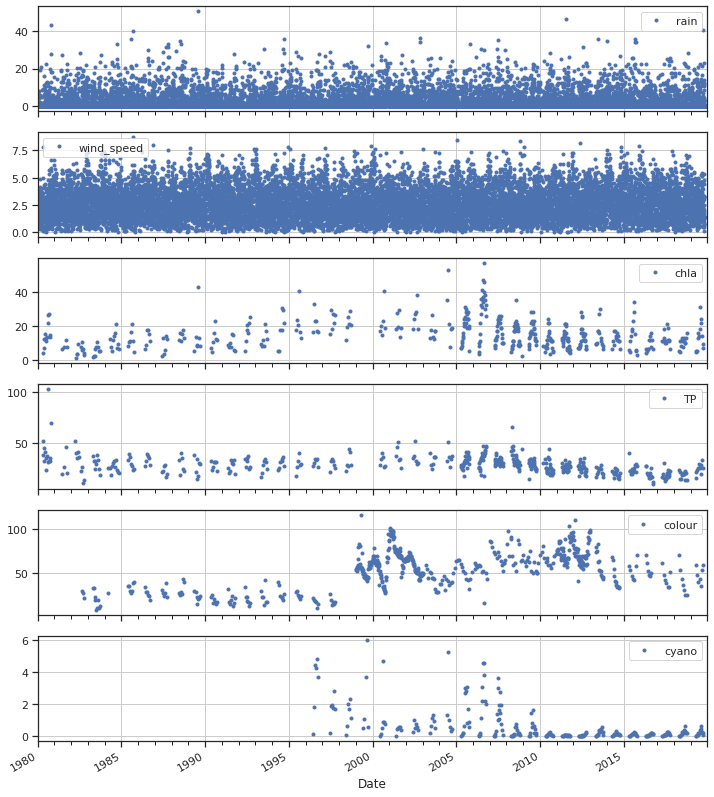

In [6]:
# REINDEX & JOIN ALL DATASETS INTO ONE DATAFRAME

df_list = [met_df, lakewq_df, ecol_df]

for i, df in enumerate(df_list):
    df = df.reindex(index=met_df.index)
    if i<1:
        daily_df = df
    else:
        daily_df = daily_df.join(df)

# Remove data pre-1980
daily_df = daily_df.loc['1980-01-01':,:]

# Rename some cols
var_rename_dict = {'Biovolume_mm3_per_l':'Biovolume',
                   'Cyano_biovol_mm3_per_l':'cyano',
                   'chl-a':'chla'}
daily_df.rename(var_rename_dict, axis=1, inplace=True)

cols_to_keep = ['TP','chla','colour','cyano',
               'rain','wind_speed']

for col in daily_df.columns:
    if col not in cols_to_keep:
        daily_df.drop(col, axis=1, inplace=True)

# Check output
daily_df.head()

daily_fig = daily_df.loc['1980-01-01':,:].plot(subplots=True, style='o', ms=3,
                                               figsize=(12,15), grid=True);

# Resample to seasonal and tidy

Define two seasons per year. Lake sampling is from mid-April to mid-October, WFD status calculated as the average or maximum observed over the growing season, defined as May-Oct. So use WFD-based season definition of 'summer' vs 'winter'.

In [8]:
agg_method_dict = {'rain': np.nansum,
                   'colour': np.nanmean,
                   'TP': np.nanmean,
                   'chla': np.nanmean,
                   'wind_speed': np.nanmean,
                   'cyano': np.nanmax
                  }

summer_df = bn.daily_to_summer_season(daily_df)
       
# Add previous summer values for selected cols
prevSummerCols = summer_df[['colour','TP','chla']].shift(+1)
prevSummerCols = prevSummerCols.add_suffix('_prevSummer')
summer_df = summer_df.join(prevSummerCols)

# Truncate start and end years so covers period 1981-end year (incl.)
summer_df = summer_df.loc[1981:end_yr_dict[met_source],:]

summer_df.head()

,rain,colour,TP,chla,wind_speed,cyano,colour_prevSummer,TP_prevSummer,chla_prevSummer
year,,,,,,,,,
1981,508.556005,NaN,28.833333,8.331250,2.471487,NaN,NaN,43.573016,16.08013
1982,557.770616,26.666667,26.988095,5.975000,2.673500,NaN,NaN,28.833333,8.33125
1983,459.499582,17.625000,29.781250,6.050000,2.735913,NaN,26.666667,26.988095,5.97500
1984,599.917631,NaN,26.527500,11.090000,2.415682,NaN,17.625000,29.781250,6.05000
1985,533.917587,34.404762,30.957143,11.895238,2.390617,NaN,NaN,26.527500,11.09000


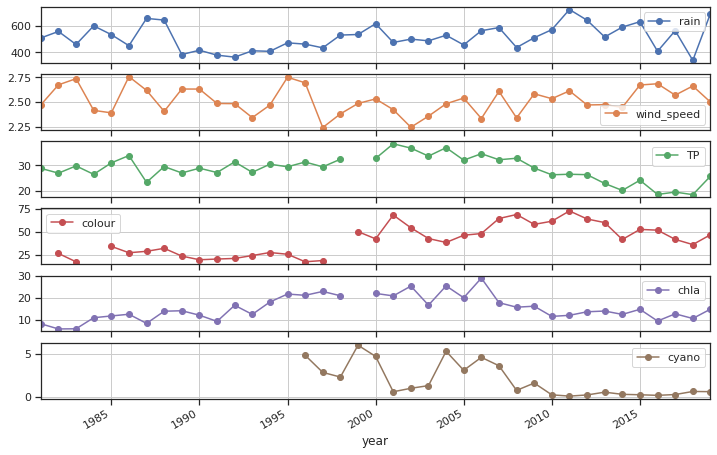

In [9]:
# Quick check of output
vars_to_plot = ['rain','wind_speed','TP','colour','chla','cyano']
ax = summer_df[vars_to_plot].plot(subplots=True, figsize=(12,8), grid=True, marker='o')
for i in range(len(vars_to_plot)-1):
    ax[i].xaxis.grid(True, which='minor', linestyle='-', linewidth=0.5)

plt.savefig(tseries_plot_fpath)

In [10]:
# Transform cyano data using boxcox transformation to make ~Gaussian
summer_df_bxcx = summer_df.copy()
for col in ['cyano']:
    summer_df_bxcx[col] = boxcox(summer_df_bxcx[col].values, lmbda=0.1)

/opt/conda/lib/python3.7/site-packages/scipy/stats/morestats.py:1038: RuntimeWarning: invalid value encountered in less_equal
  if any(x <= 0):


In [12]:
# Write to csv
summer_df[['TP','chla','colour','cyano']].to_csv(out_file_obs)
summer_df_bxcx.to_csv(out_file_training)